In [1]:
from pathlib import Path

import scipy.io as sio
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
from linear_operator import settings

import famgpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.manual_seed(42)

DATA_DIR = Path("../data/Data")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {torch.cuda.get_device_name(device) if device.type == 'cuda' else 'CPU'}.")

Training on NVIDIA GeForce RTX 3080.


## Read data

In [2]:
data_names = [
    "Phase current U",
    "Phase current V",
    "Phase current W",
    "Phase voltage U",
    "Phase voltage V",
    "Phase voltage W",
    "DC-Bus voltage",
    "Mechanical angle",
    "Current vector",
    "Mechanical speed",
    "Speed deviation"
]

mat_arr = sio.loadmat(str(Path(DATA_DIR, "H1.5.mat")))['StromBox_Werte'][:12,:356*3].astype(np.float32)
num_tasks = 11
train_x = torch.from_numpy(mat_arr[0]).to(device)

data = mat_arr[1:num_tasks+1]
means = [np.mean(row) for row in data]
stds = [np.std(row) if np.std(row) != 0 else np.float32(1) for row in data]
data = [torch.from_numpy((row - mean) / std) for row, mean, std in zip(data, means, stds)]
train_y = torch.stack(data, dim=1).to(device)

## Setting up the models

In [3]:
class ConventionalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ConventionalGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel() * gpytorch.kernels.RBFKernel()), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

class ApproxGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ApproxGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=num_tasks
        )
        self.covar_module = famgpytorch.kernels.MultitaskKernelLinearCG(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel() * famgpytorch.kernels.RBFKernelApprox(number_of_eigenvalues=30)), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

task_noise_covar_rank = 0
conv_likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=task_noise_covar_rank)
conv_likelihood.to(device)
conv_model = ConventionalGPModel(train_x, train_y, conv_likelihood)
conv_model.to(device)

approx_likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=task_noise_covar_rank)
approx_likelihood.to(device)
approx_model = ApproxGPModel(train_x, train_y, approx_likelihood)
approx_model.to(device)

# initialize task kernel and noise hyperparameters to make GPs comparable
hypers = {
    'covar_module.task_covar_module.covar_factor': torch.randn(num_tasks, 1, device=device),
    'covar_module.task_covar_module.raw_var': torch.randn(num_tasks, device=device),
}
if task_noise_covar_rank != 0:
    hypers['likelihood.task_noise_covar_factor'] = torch.randn(num_tasks, task_noise_covar_rank, device=device)
conv_model.initialize(**hypers)
approx_model.initialize(**hypers)
None

## Training the model

In [4]:
# set model in training mode
conv_model.train()
approx_model.train()
conv_likelihood.train()
approx_likelihood.train()

# use adam optimizer, including the GaussianLikelihood parameters
conv_optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.01)
approx_optimizer = torch.optim.Adam(approx_model.parameters(), lr=0.01)

# "Loss" for GPs - marginal log likelihood
conv_mll = gpytorch.mlls.ExactMarginalLogLikelihood(conv_likelihood, conv_model)
approx_mll = gpytorch.mlls.ExactMarginalLogLikelihood(approx_likelihood, approx_model)

n_iter = 400
print("Conventional:")
for i in range(n_iter):
    conv_optimizer.zero_grad()
    conv_output = conv_model(train_x)
    conv_loss = -conv_mll(conv_output, train_y)
    conv_loss.backward()
    if i == 0 or (i + 1) % 100 == 0:
        if task_noise_covar_rank == 0:
            task_noises = conv_model.likelihood.task_noises.tolist()
        else:
            task_noises = conv_model.likelihood.task_noise_covar_factor.tolist()
        print(
            f"\tIter {i + 1:02d}/{n_iter}\n"
            f"\t\tLoss: {' ' if conv_loss.item() >= 0 else ''}{conv_loss.item():.3f}   "
            f"period_length: {conv_model.covar_module.data_covar_module.base_kernel.kernels[0].period_length.item():.3f}   "
            f"lengthscale: {conv_model.covar_module.data_covar_module.base_kernel.kernels[1].lengthscale.item():.3f}   "
            f"outputscale: {conv_model.covar_module.data_covar_module.outputscale.item():.3f}\n"
            f"\t\ttask_noises: {np.around(np.array(task_noises), 3).tolist()}   "
            f"global_noise: {conv_model.likelihood.noise.item():.3f}"
        )
    conv_optimizer.step()

print("Approximate")
for i in range(n_iter):
    approx_optimizer.zero_grad()
    approx_output = approx_model(train_x)
    approx_loss = -approx_mll(approx_output, train_y)
    approx_loss.backward()
    if i == 0 or (i + 1) % 100 == 0:
        if task_noise_covar_rank == 0:
            task_noises = approx_model.likelihood.task_noises.tolist()
        else:
            task_noises = approx_model.likelihood.task_noise_covar_factor.tolist()
        print(
            f"\tIter {i + 1:02d}/{n_iter}\n"
            f"\t\tLoss: {' ' if approx_loss.item() >= 0 else ''}{approx_loss.item():.3f}   "
            f"period_length: {approx_model.covar_module.data_covar_module.base_kernel.kernels[0].period_length.item():.3f}   "
            f"lengthscale: {approx_model.covar_module.data_covar_module.base_kernel.kernels[1].lengthscale.item():.3f}   "
            f"outputscale: {approx_model.covar_module.data_covar_module.outputscale.item():.3f}\n"
            f"\t\ttask_noises: {np.around(np.array(task_noises), 3).tolist()}   "
            f"global_noise: {approx_model.likelihood.noise.item():.3f}   "
            f"alpha: {approx_model.covar_module.data_covar_module.base_kernel.kernels[1].alpha.item():.3f}"
        )
    approx_optimizer.step()

Conventional:
	Iter 01/400
		Loss:  1.428   period_length: 0.693   lengthscale: 0.693   outputscale: 0.693
		task_noises: [0.693, 0.693, 0.693, 0.693, 0.693, 0.693, 0.693, 0.693, 0.693, 0.693, 0.693]   global_noise: 0.693
	Iter 100/400
		Loss:  1.339   period_length: 0.265   lengthscale: 0.209   outputscale: 1.407
		task_noises: [0.502, 0.491, 0.527, 0.507, 0.489, 0.525, 0.528, 0.38, 0.344, 0.512, 0.32]   global_noise: 0.426
	Iter 200/400
		Loss:  1.254   period_length: 0.077   lengthscale: 0.062   outputscale: 2.110
		task_noises: [0.639, 0.581, 0.732, 0.634, 0.579, 0.731, 0.726, 0.193, 0.124, 0.681, 0.149]   global_noise: 0.247
	Iter 300/400
		Loss:  0.577   period_length: 0.018   lengthscale: 0.013   outputscale: 2.884
		task_noises: [0.168, 0.164, 0.195, 0.163, 0.171, 0.193, 0.889, 0.057, 0.114, 0.855, 0.151]   global_noise: 0.075
	Iter 400/400
		Loss:  0.091   period_length: 0.015   lengthscale: 0.010   outputscale: 2.679
		task_noises: [0.028, 0.027, 0.032, 0.027, 0.028, 0.031, 0

## Make predictions

C:\Users\pasca\Documents\Studienarbeit\PythonProject\.venv\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


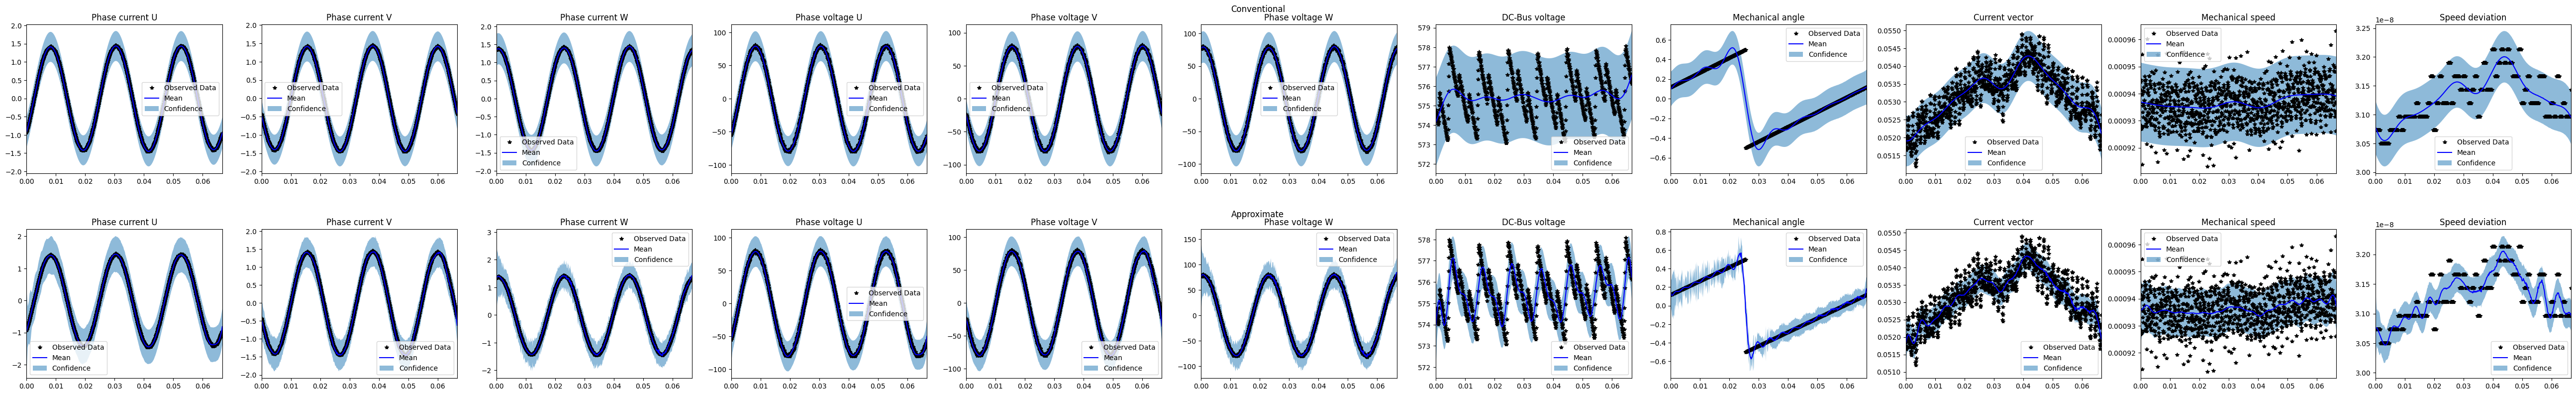

In [5]:
# Set into eval mode
conv_model.eval()
conv_likelihood.eval()
approx_model.eval()
approx_likelihood.eval()

# Make predictions
with torch.no_grad(), settings.max_cg_iterations(10000):
    test_x = torch.linspace(0, train_x.max(), int(train_x.size(0)/2.1), device=device)

    conv_predictions = conv_likelihood(conv_model(test_x))
    approx_predictions = approx_likelihood(approx_model(test_x))

    # This contains predictions for both tasks, flattened out
    # The first half of the predictions is for the first task
    # The second half is for the second task

    # Initialize plots
    f = plt.figure(figsize=(6*num_tasks, 8))
    subfigs = f.subfigures(2, 1, hspace=0.06)
    subfigs[0].suptitle("Conventional")
    subfigs[1].suptitle("Approximate")
    for row, predictions in enumerate([conv_predictions, approx_predictions]):
        mean = predictions.mean.to('cpu')
        lower, upper = (tensor.to('cpu') for tensor in predictions.confidence_region())
        train_x = train_x.to('cpu')
        train_y = train_y.to('cpu')
        test_x = test_x.to('cpu')

        axs = subfigs[row].subplots(1, num_tasks)
        for i, ax in enumerate(axs):# Plot training data as black stars
            ax.plot(train_x.detach().numpy(), (train_y[:, i]*stds[i]+means[i]).detach().numpy(), 'k*')
            # Predictive mean as blue line
            ax.plot(test_x.numpy(), (mean[:, i]*stds[i]+means[i]).numpy(), 'b')
            # Shade in confidence
            ax.fill_between(test_x.numpy(), (lower[:, i]*stds[i]+means[i]).numpy(), (upper[:, i]*stds[i]+means[i]).numpy(), alpha=0.5)
            ax.set_xlim([test_x.min(), test_x.max()])
            ax.legend(['Observed Data', 'Mean', 'Confidence'])
            ax.set_title(data_names[i])

    plt.savefig('./temp/test/plots/pred.png')